# BLE Beacon Localization

## Overview
This Jupyter Notebook simulates a beacon-based localization system where the positions of beacons are known, and the Received Signal Strength Indicator (RSSI) values from these beacons are used to estimate the position of a device. The notebook provides a way to simulate the system using example RSSI values and visualizes the estimated position based on those values.


In [1]:
# Prereqs
!pip install bleak numpy matplotlib pyyaml

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from bleak import BleakScanner
import time
import yaml
from pprint import pprint

In [3]:
# Beacon positions (3D coordinates based on the provided data)
beacons_yaml = """
beacons:
  "48:87:2D:76:4E:A6":
    name: "mbr"
    x: 6.6
    y: 9.1
    z: 3.1
    rssi: 0
  "48:87:2D:76:4E:A1":
    name: "chloe"
    x: 0.5
    y: 9.1
    z: 4.5
    rssi: 0
  "48:87:2D:76:4E:93":
    name: "laundry"
    x: 5.2
    y: 3.96
    z: 4.6
    rssi: 0
  "48:87:2D:76:4E:96":
    name: "garage"
    x: 0.3
    y: 2.0
    z: 1.0
    rssi: 0
"""

beacons = yaml.safe_load(beacons_yaml)
beacons = beacons['beacons']
pprint(beacons)

{'48:87:2D:76:4E:93': {'name': 'laundry',
                       'rssi': 0,
                       'x': 5.2,
                       'y': 3.96,
                       'z': 4.6},
 '48:87:2D:76:4E:96': {'name': 'garage',
                       'rssi': 0,
                       'x': 0.3,
                       'y': 2.0,
                       'z': 1.0},
 '48:87:2D:76:4E:A1': {'name': 'chloe',
                       'rssi': 0,
                       'x': 0.5,
                       'y': 9.1,
                       'z': 4.5},
 '48:87:2D:76:4E:A6': {'name': 'mbr', 'rssi': 0, 'x': 6.6, 'y': 9.1, 'z': 3.1}}


## RSSI to Distance Conversion
The rssi_to_distance function converts RSSI values to estimated distances in meters. This conversion uses a logarithmic formula that accounts for the fact that signal strength decreases logarithmically with distance. The formula parameters, such as the reference RSSI value at 1 meter (rssi_ref) and the path-loss exponent (path_loss_exponent), can be adjusted based on the environment.

In [4]:
import numpy as np

# Provided known distances and RSSI values
known_distances = np.array([1.0, 2.8956, 3.2004, 5.1, 5.1054, 8.86])
known_rssi = np.array([-53, -65.4, -76.7143, -80.333, -81, -86.2])

# Function to convert RSSI to distance
def rssi_to_distance(rssi, rssi_ref=-60, path_loss_exponent=3):
    return 10 ** ((rssi_ref - rssi) / (10 * path_loss_exponent))

# Calculate distances using the RSSI values
calculated_distances = rssi_to_distance(known_rssi)

# Compare known distances with calculated distances (The left and right column should be as close to matching as possible)
comparison = np.vstack((known_distances, calculated_distances)).T
comparison

array([[1.        , 0.58434141],
       [2.8956    , 1.51356125],
       [3.2004    , 3.60697667],
       [5.1       , 4.76175084],
       [5.1054    , 5.01187234],
       [8.86      , 7.47021899]])

In [5]:
rssi_to_distance(-70)

2.154434690031884

### Analysis:
- Underestimation at Close Distances: The calculated distances are generally lower than the known distances for the first two pairs. This suggests that the current `rssi_ref` and `path_loss_exponent` may be underestimating distances at closer ranges.
- Closer Alignment at Mid-Range: The calculated distances for mid-range values (around 5 meters) are relatively close to the known distances.
- Underestimation at Long Distances: At the longest distance (8.86 meters), the calculated distance is again lower than the known distance.

### Next Steps:
1. Adjust Parameters: You may need to adjust the `rssi_ref` (reference RSSI at 1 meter) and `path_loss_exponent` values to better fit the environment you’re working in. For example:
    - Increase `rssi_ref` to make calculated distances longer.
    - Decrease `path_loss_exponent` to reduce the decay rate of the signal with distance.
1. Re-Test: After adjusting these parameters, re-calculate the distances and compare them to the known values again.



## Position Calculation
The calculate_position function estimates the device's position by calculating a weighted average of the beacon positions. The weights are determined by the inverse of the distances derived from the RSSI values. This method provides a more accurate and linear estimation of the position.

In [6]:
# Just figure out the midpoint for reference
import numpy as np

# Get the x, y, and z coordinates of all the beacons
x_coordinates = np.array([beacon["x"] for beacon in beacons.values()])
y_coordinates = np.array([beacon["y"] for beacon in beacons.values()])
z_coordinates = np.array([beacon["z"] for beacon in beacons.values()])

# Calculate the midpoint
midpoint = np.mean(x_coordinates), np.mean(y_coordinates), np.mean(z_coordinates)
midpoint

(np.float64(3.1500000000000004), np.float64(6.04), np.float64(3.3))

In [7]:
# Calculate position based on RSSI (using weighted average method with distance conversion)
def calculate_position(beacons):
    rssi_values = [beacon["rssi"] for beacon in beacons.values() if beacon["rssi"] != 0]
    
    # Check if there are any valid RSSI values after filtering out zeros
    if len(rssi_values) == 0:
        return None, None, None  # No valid RSSI data
    
    # Check if all remaining RSSI values are the same
    if all(rssi == rssi_values[0] for rssi in rssi_values):
        # Average the positions directly (midpoint)
        x = np.mean([beacon["x"] for beacon in beacons.values() if beacon["rssi"] != 0])
        y = np.mean([beacon["y"] for beacon in beacons.values() if beacon["rssi"] != 0])
        z = np.mean([beacon["z"] for beacon in beacons.values() if beacon["rssi"] != 0])
    else:
        distances = {beacon_id: rssi_to_distance(beacon["rssi"]) for beacon_id, beacon in beacons.items() if beacon["rssi"] != 0}
        distance_sum = sum(1 / d for d in distances.values())
        
        # Compute weighted position based on distances
        x = sum(beacons[beacon_id]["x"] * (1 / distances[beacon_id]) / distance_sum for beacon_id in distances)
        y = sum(beacons[beacon_id]["y"] * (1 / distances[beacon_id]) / distance_sum for beacon_id in distances)
        z = sum(beacons[beacon_id]["z"] * (1 / distances[beacon_id]) / distance_sum for beacon_id in distances)

    return x, y, z

test_beacons = {
    "48:87:2D:76:4E:A6": {"name": "mbr", "x": 6.6, "y": 9.1, "z": 3.1, "rssi": -70},
    "48:87:2D:76:4E:A1": {"name": "chloe", "x": 0.5, "y": 9.1, "z": 4.5, "rssi": -70},
    "48:87:2D:76:4E:93": {"name": "laundry", "x": 5.2, "y": 3.96, "z": 4.6, "rssi": -70},
    "48:87:2D:76:4E:96": {"name": "garage", "x": 0.3, "y": 2.0, "z": 1.0, "rssi": -70},
}
# Calculate the midpoint of the beacons

calculate_position(beacons)


(None, None, None)

In [8]:
# Visualize position
def visualize_position(beacons, position):
    plt.figure(figsize=(8, 6))
    plt.grid(True)
    
    # Plot beacons
    for beacon_id, beacon in beacons.items():
        plt.scatter(beacon["x"], beacon["y"], label=f'{beacon["name"]} ({beacon["rssi"]} dBm)', s=100)
    
    # Plot calculated position
    if position[0] is not None:
        plt.scatter(position[0], position[1], color='red', label='Estimated Position', s=200, marker='x')
    
    plt.title("Beacon Positions and Estimated Position")
    plt.xlabel("X Coordinate (meters)")
    plt.ylabel("Y Coordinate (meters)")
    plt.legend()
    plt.show()

# Static Example

(4.214686497789163, 7.689667776258289, 3.719944412968524)


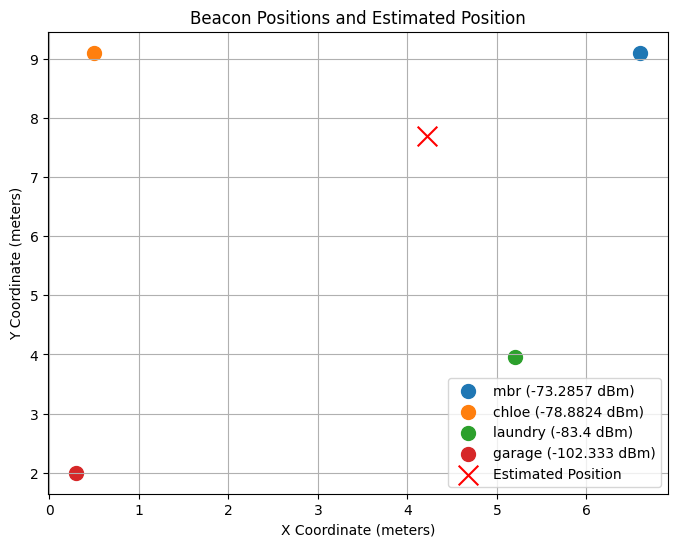

In [9]:
# Beacon positions (3D coordinates based on the provided data)
test_beacons = {
    "48:87:2D:76:4E:A6": {"name": "mbr", "x": 6.6, "y": 9.1, "z": 3.1, "rssi": -73.2857},
    "48:87:2D:76:4E:A1": {"name": "chloe", "x": 0.5, "y": 9.1, "z": 4.5, "rssi": -78.8824},
    "48:87:2D:76:4E:93": {"name": "laundry", "x": 5.2, "y": 3.96, "z": 4.6, "rssi": -83.4},
    "48:87:2D:76:4E:96": {"name": "garage", "x": 0.3, "y": 2.0, "z": 1.0, "rssi": -102.333},
}

# Calculate the estimated position
position = calculate_position(test_beacons)
pprint(position)

# Visualize the beacons and the estimated position
visualize_position(test_beacons, position)

In [10]:
# Reset RSSI values to 0
def reset_rssi(beacons):
    for beacon in beacons.values():
        beacon["rssi"] = 0

In [11]:
# Visualize the RSSI values over time
def visualize_rssi_over_time(rssi_over_time):
    plt.figure(figsize=(10, 6))
    
    for beacon_id, rssi_values in rssi_over_time.items():
        times, rssis = zip(*rssi_values)
        plt.plot(times, rssis, label=beacons[beacon_id]['name'])
    
    plt.title("RSSI Values Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("RSSI (dBm)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
import asyncio
from collections import defaultdict, deque

# Initialize tracking variables
callback_count = defaultdict(int)
rssi_over_time = defaultdict(lambda: deque(maxlen=100))
start_time = time.time()

# Scan for Bluetooth devices and update RSSI values
async def scan_bluetooth():
    reset_rssi(beacons)  # Reset RSSI values before scanning
    
    def detection_callback(device, advertisement_data):
        if device.address in beacons:
            beacons[device.address]["rssi"] = advertisement_data.rssi
            callback_count[device.address] += 1  # Track callback count
            current_time = time.time() - start_time
            rssi_over_time[device.address].append((current_time, advertisement_data.rssi))
            print(f"Updated {beacons[device.address]['name']} with RSSI: {advertisement_data.rssi} dBm")

    # Use detection_callback directly in the BleakScanner constructor
    scanner = BleakScanner(detection_callback=detection_callback)
    await scanner.start()
    await asyncio.sleep(300)  # Scan for 5 seconds
    await scanner.stop()

# Run the scan asynchronously
await scan_bluetooth()


Updated mbr with RSSI: -81 dBm
Updated laundry with RSSI: -99 dBm
Updated chloe with RSSI: -77 dBm
Updated mbr with RSSI: -103 dBm
Updated laundry with RSSI: -101 dBm
Updated chloe with RSSI: -75 dBm
Updated mbr with RSSI: -89 dBm
Updated mbr with RSSI: -89 dBm
Updated chloe with RSSI: -77 dBm
Updated chloe with RSSI: -77 dBm
Updated laundry with RSSI: -101 dBm
Updated laundry with RSSI: -99 dBm
Updated mbr with RSSI: -89 dBm
Updated chloe with RSSI: -77 dBm
Updated laundry with RSSI: -91 dBm
Updated chloe with RSSI: -77 dBm
Updated laundry with RSSI: -101 dBm
Updated laundry with RSSI: -99 dBm
Updated mbr with RSSI: -77 dBm
Updated mbr with RSSI: -77 dBm
Updated mbr with RSSI: -77 dBm
Updated chloe with RSSI: -75 dBm
Updated chloe with RSSI: -77 dBm
Updated chloe with RSSI: -77 dBm
Updated laundry with RSSI: -89 dBm
Updated laundry with RSSI: -89 dBm
Updated mbr with RSSI: -79 dBm
Updated mbr with RSSI: -79 dBm
Updated chloe with RSSI: -83 dBm
Updated laundry with RSSI: -99 dBm
Update

(4.164421884904888, 8.450166323994338, 3.808002942103245)


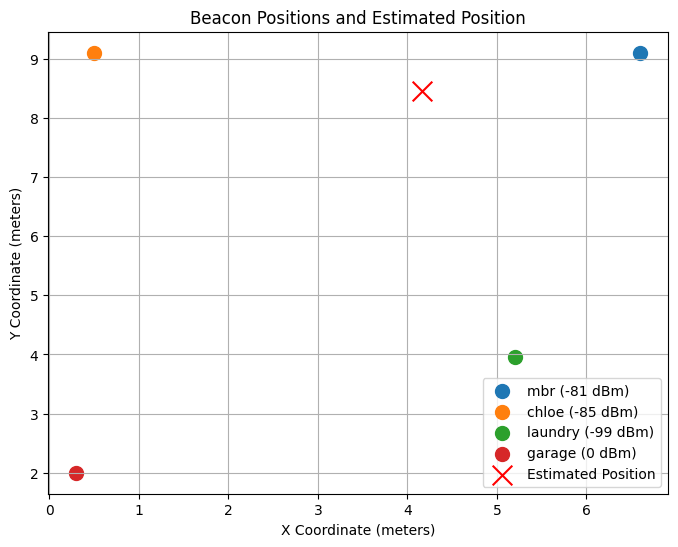

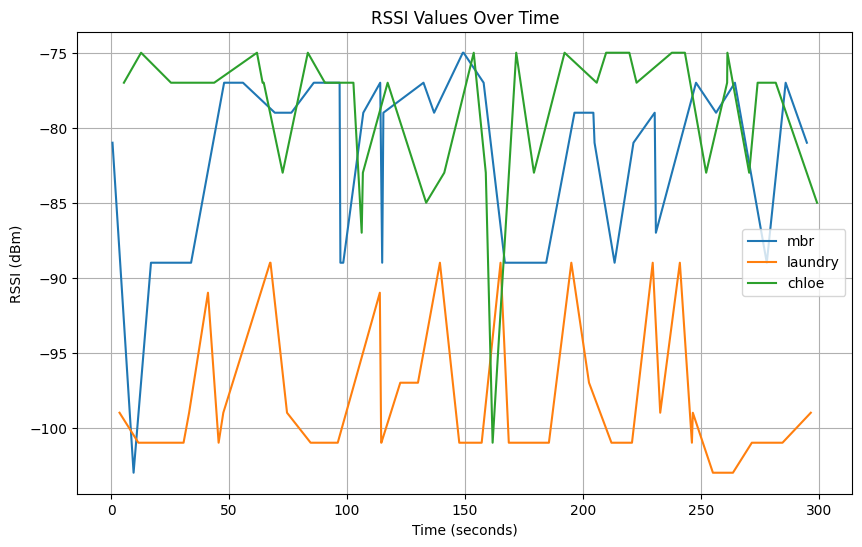

In [13]:
# Calculate the estimated position
position = calculate_position(beacons)
pprint(position)

# Visualize the beacons and the estimated position
visualize_position(beacons, position)

# Visualize the RSSI values over time
visualize_rssi_over_time(rssi_over_time)

In [14]:
def show_distance_from_beacons(beacons):
    for beacon_id, beacon in beacons.items():
        distance_x = beacon["x"] - position[0]
        distance_y = beacon["y"] - position[1]
        print(f"Distance from {beacon['name']}: x = {distance_x}, y = {distance_y}")

show_distance_from_beacons(beacons)

Distance from mbr: x = 2.4355781150951117, y = 0.6498336760056613
Distance from chloe: x = -3.664421884904888, y = 0.6498336760056613
Distance from laundry: x = 1.0355781150951122, y = -4.490166323994338
Distance from garage: x = -3.864421884904888, y = -6.450166323994338
